In [13]:
import pickle as pkl

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import glob
from matplotlib.colors import LogNorm
import pandas
import json
import sklearn
import sklearn.metrics
import bz2
import mpl_toolkits
import mplhep as hep
import itertools

plt.style.use(hep.style.ROOT)

In [14]:
def midpoints(x):
    return x[:-1] + np.diff(x)/2

def mask_empty(hist):
    h0 = hist[0].astype(np.float64)
    h0[h0<50] = 0
    return (h0, hist[1])

def divide_zero(a, b):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    out = np.zeros_like(a)
    np.divide(a, b, where=b>0, out=out)
    return out

pid_names = {
    0: "None",
    1: "Charged hadrons",
    2: "Neutral hadrons",
    3: "Photons",
    4: "Electrons",
    5: "Muons",
}

In [18]:
with open('../../test_tmp_delphes/data/pythia8_qcd/raw/tev14_pythia8_qcd_10_0.pkl', 'rb') as pickle_file:
    data = pkl.load(pickle_file)
    
data.keys()

dict_keys(['X', 'ycand', 'ygen'])

The dataset contains three main collections:
  - `X` - the list of reco object arrays (one `[Nobj x Nfeat_reco]` array per event)
  - `ycand` - the list of PFCandidate arrays (one `[Nobj x Nfeat_part]` array per event)
  - `ygen` - the list of GenParticles arrays (one `[Nobj x Nfeat_part]` array per event)
    
In CS terms: we use X as input to predict the target "ygen".

However, "ycand" is useful because it is the prediction of the particle flow algorithm already implemeneted in the detector (the one we're trying to replace using ML).. we often refer to the "ycand" prediction as rule-based PF.

This file contains 100 events.

In [19]:
len(data["X"]), len(data["ycand"]), len(data["ygen"])

(100, 100, 100)

Let's look at the reco objects in the first event.

In [20]:
data["X"][0].shape

(4867, 12)

Recall that we have two types of nodes in our input graphs: tracks, clusters.

The X array contains 4867 reco objects (calo clusters and tracks concatenated to a single array) for this event, for each reco object we have the following features.

Calo cluster features:
  - 0: type=1
  - 1: transverse energy [GeV]
  - 2: eta
  - 3: sin(phi)
  - 4: cos(phi)
  - 5: total energy (GeV)
  - 6: electromagnetic energy (GeV)
  - 7: hadronic energy
  - 8-11: empty
  
Track features:
  - 0: type=2
  - 1: pT [GeV]
  - 2: eta
  - 3: sin(phi)
  - 4: cos(phi)
  - 5: P (GeV)
  - 6: eta_outer (GeV)
  - 7: sin(phi_outer)
  - 8: cos(phi_outer)
  - 9: charge
  - 10: is_gen_muon (set to 1 for tracks from generator muons to mimic Delphes PF)
  - 11: is_gen_electron (set to 1 for tracks from generator electrons to mimic Delphes PF)

In [22]:
data["ygen"][0].shape, data["ycand"][0].shape

((4867, 7), (4867, 7))

The GenParticle and PFCandidate arrays have the same features.

  - 0: PID code
    - PID==0: no particle
    - PID==1: charged hadron
    - PID==2: neutral hadron
    - PID==3: photon
    - PID==4: electron
    - PID==5: muon
  - 1: charge
  - 2: pT
  - 3: eta
  - 4: sin phi
  - 5: cos phi
  - 6: energy

## Particle multiplicities

Text(0, 1, 'Number of rule-based PF\nparticles per event')

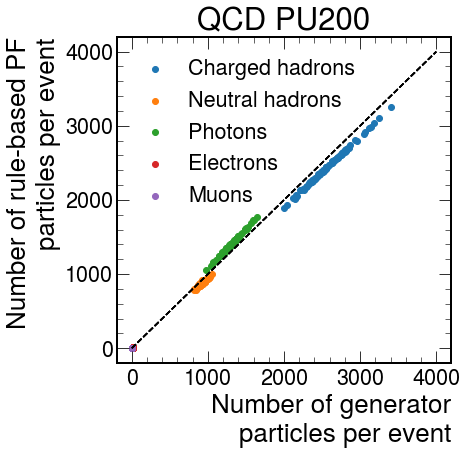

In [23]:
plt.figure(figsize=(6,6))
for pid in [1,2,3,4,5]:
    npid_gen = [np.sum(y[:, 0]==pid) for y in data["ygen"]]
    npid_cand = [np.sum(y[:, 0]==pid) for y in data["ycand"]]
    plt.scatter(npid_gen, npid_cand, label=pid_names[pid])
    plt.plot([0,4000],[0,4000], color="black", ls="--")
plt.legend()
plt.title("QCD PU200")
plt.xlabel("Number of generator\nparticles per event")
plt.ylabel("Number of rule-based PF\nparticles per event")

## GenParticle kinematics

In [24]:
X = np.concatenate(data["X"])
ygen = np.concatenate(data["ygen"])
ycand = np.concatenate(data["ycand"])

Text(0, 1, 'Truth particles')

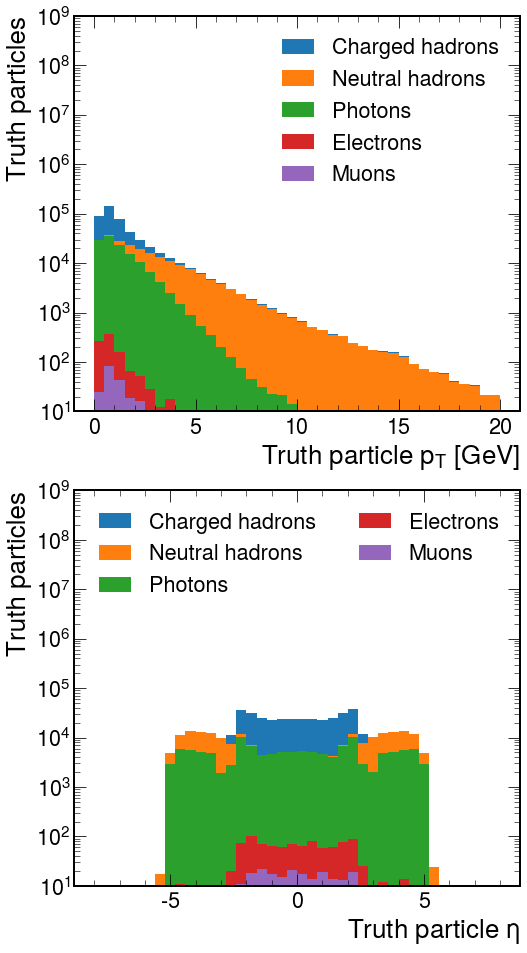

In [25]:
b = np.linspace(0, 20, 41)

msk_pid1 = (ygen[:, 0]==1)
msk_pid2 = (ygen[:, 0]==2)
msk_pid3 = (ygen[:, 0]==3)
msk_pid4 = (ygen[:, 0]==4)
msk_pid5 = (ygen[:, 0]==5)

h1 = np.histogram(ygen[msk_pid1, 2], bins=b)
h2 = np.histogram(ygen[msk_pid2, 2], bins=b)
h3 = np.histogram(ygen[msk_pid3, 2], bins=b)
h4 = np.histogram(ygen[msk_pid4, 2], bins=b)
h5 = np.histogram(ygen[msk_pid5, 2], bins=b)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 2*8))

xs = midpoints(h1[1])
width = np.diff(h1[1])

hep.histplot([h5[0], h4[0], h3[0], h2[0], h1[0]], bins=h1[1], ax=ax1, stack=True, histtype="fill",
    label=["Muons", "Electrons", "Photons", "Neutral hadrons", "Charged hadrons"])

ax1.legend(loc="best", frameon=False)
ax1.set_yscale("log")
ax1.set_ylim(1e1, 1e9)
ax1.set_xlabel(r"Truth particle $p_\mathrm{T}$ [GeV]")
ax1.set_ylabel("Truth particles")

b = np.linspace(-8, 8, 41)
h1 = np.histogram(ygen[msk_pid1, 3], bins=b)
h2 = np.histogram(ygen[msk_pid2, 3], bins=b)
h3 = np.histogram(ygen[msk_pid3, 3], bins=b)
h4 = np.histogram(ygen[msk_pid4, 3], bins=b)
h5 = np.histogram(ygen[msk_pid5, 3], bins=b)
xs = midpoints(h1[1])
width = np.diff(h1[1])

hep.histplot([h5[0], h4[0], h3[0], h2[0], h1[0]], bins=h1[1], ax=ax2, stack=True, histtype="fill",
    label=["Muons", "Electrons", "Photons", "Neutral hadrons", "Charged hadrons"])
ax2.legend(loc="best", frameon=False, ncol=2)
ax2.set_yscale("log")
ax2.set_ylim(1e1, 1e9)
ax2.set_xlabel("Truth particle $\eta$")
ax2.set_ylabel("Truth particles")

## Reco object to particle association

In [26]:
X_ygen_matrix = sklearn.metrics.confusion_matrix(
    X[:, 0], ygen[:, 0], labels=range(6)
)
X_ycand_matrix = sklearn.metrics.confusion_matrix(
    X[:, 0], ycand[:, 0], labels=range(6)
)

Text(0.5, 1.0, 'Reco object to GenParticle association')

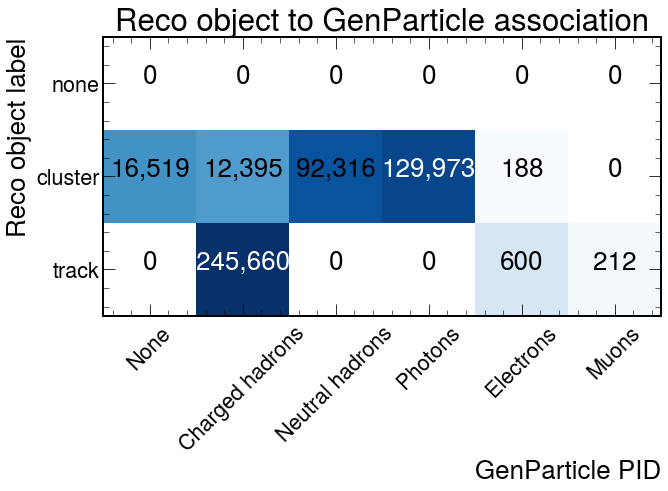

In [27]:
ax = plt.axes()
ax.imshow(X_ygen_matrix[:3, :], cmap="Blues", norm=matplotlib.colors.LogNorm())
ax.set_yticks(range(3))
ax.set_yticklabels(["none", "cluster", "track"])
ax.set_xticks(range(6))
ax.set_xticklabels([pid_names[p] for p in range(6)], rotation=45);
ax.set_xlabel("GenParticle PID")
ax.set_ylabel("Reco object label")

for i, j in itertools.product(range(3), range(6)):
    ax.text(j, i, "{:,}".format(X_ygen_matrix[i, j]),
             horizontalalignment="center",
             color="white" if X_ygen_matrix[i, j] > X_ygen_matrix.max()/2 else "black")
    
plt.title("Reco object to GenParticle association")


Text(0.5, 1.0, 'Reco object to PFCandidate association')

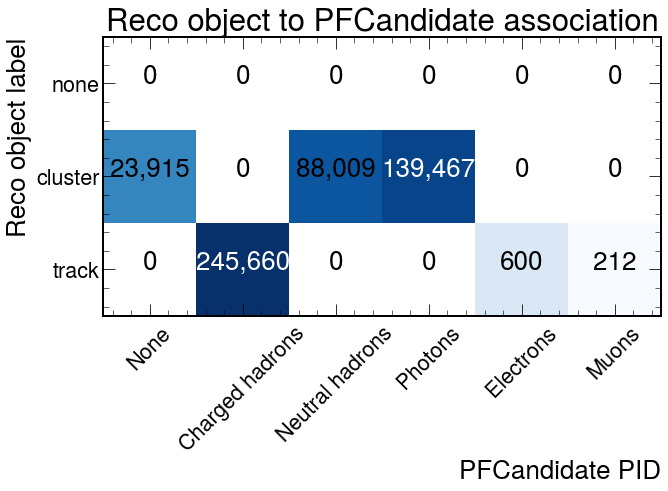

In [28]:
ax = plt.axes()
ax.imshow(X_ycand_matrix[:3, :], cmap="Blues", norm=matplotlib.colors.LogNorm())
ax.set_yticks(range(3))
ax.set_yticklabels(["none", "cluster", "track"])
ax.set_xticks(range(6))
ax.set_xticklabels([pid_names[p] for p in range(6)], rotation=45);
ax.set_xlabel("PFCandidate PID")
ax.set_ylabel("Reco object label")

for i, j in itertools.product(range(3), range(6)):
    ax.text(j, i, "{:,}".format(X_ycand_matrix[i, j]),
             horizontalalignment="center",
             color="white" if X_ycand_matrix[i, j] > X_ycand_matrix.max()/2 else "black")
    
plt.title("Reco object to PFCandidate association")

Text(1, 0, '$(\\eta_{reco} - \\eta_{ptcl}) / \\eta_{reco}$')

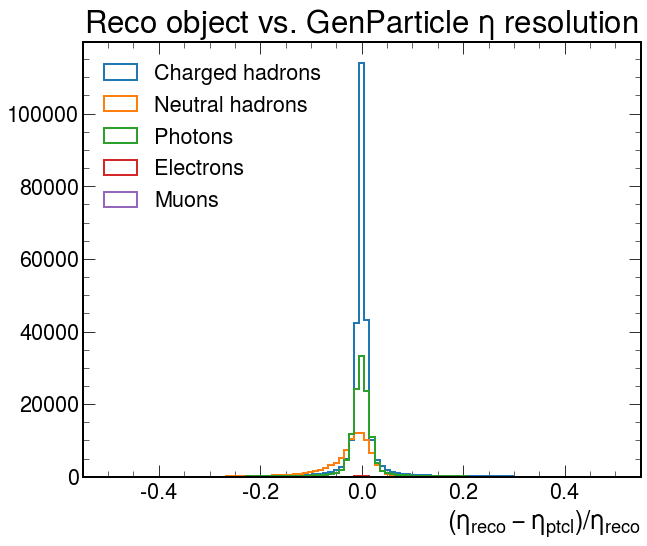

In [29]:
plt.figure(figsize=(10,8))
for pid in [1,2,3,4,5]:
    msk = ygen[:, 0] == pid
    eta_x = X[msk, 2]
    eta_y = ygen[msk, 3]
    plt.hist((eta_x-eta_y)/eta_x, bins=np.linspace(-0.5, 0.5, 100), histtype="step", lw=2, label=pid_names[pid])
plt.legend(loc=2)
plt.title("Reco object vs. GenParticle $\eta$ resolution")
plt.xlabel("$(\eta_{reco} - \eta_{ptcl}) / \eta_{reco}$")

Text(1, 0, '$(\\eta_{reco} - \\eta_{ptcl}) / \\eta_{reco}$')

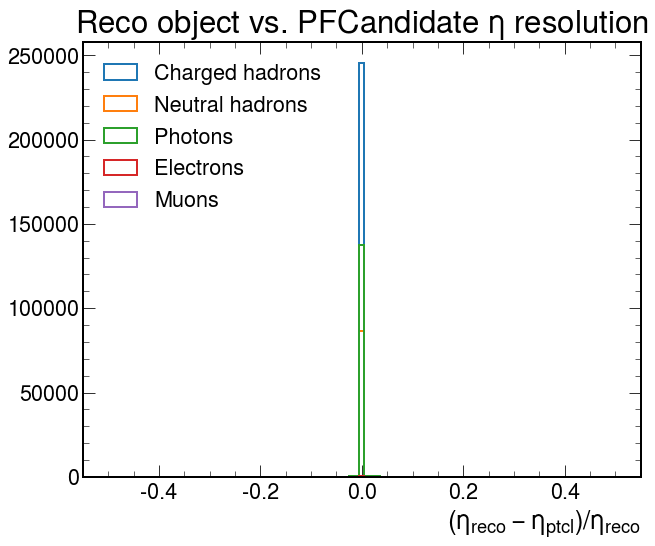

In [30]:
plt.figure(figsize=(10,8))
for pid in [1,2,3,4,5]:
    msk = ycand[:, 0] == pid
    eta_x = X[msk, 2]
    eta_y = ycand[msk, 3]
    plt.hist((eta_x-eta_y)/eta_x, bins=np.linspace(-0.5, 0.5, 100), histtype="step", lw=2, label=pid_names[pid])
plt.legend(loc=2)
plt.title("Reco object vs. PFCandidate $\eta$ resolution")
plt.xlabel("$(\eta_{reco} - \eta_{ptcl}) / \eta_{reco}$")